Fertility 

In [2]:
import pandas as pd

# ====== CONFIGURE THESE ======
excel_file = "fertility.xls"  # your .xls file
final_csv = "sahel_fertility_2010_2023.csv"

sahel_countries = [
    "Senegal",
    "Gambia",
    "Mauritania",
    "Guinea",
    "Mali",
    "BurkinaFaso",  # or "Burkina Faso" if you kept the space
    "Niger",
    "Chad",
    "Cameroon",
    "Nigeria"
]

# We WANT "CountryName" and "IndicatorName" in final output
# We do NOT want "CountryCode" or "IndicatorCode"
core_cols = ["CountryName", "IndicatorName"]
year_cols = [str(year) for year in range(2010, 2024)]  # 2010..2023
# =============================

# 1) READ .XLS, skip first 3 rows => row 4 is header
df = pd.read_excel(
    excel_file,
    engine="xlrd",
    skiprows=3,  # ignore rows 1..3
    header=0     # row 4 becomes the column headers
)

# 2) CLEAN COLUMN HEADERS: remove spaces, commas
df.columns = [col.strip().replace(" ", "").replace(",", "") for col in df.columns]

# 3) CLEAN DATA CELLS
for col in df.columns:
    df[col] = df[col].astype(str)
    df[col] = df[col].str.replace(" ", "", regex=True)
    df[col] = df[col].str.replace(",", "", regex=True)
    # Try to convert to numeric
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        pass

# 4) FILTER ROWS: keep only Sahel countries
df_sahel = df[df["CountryName"].isin(sahel_countries)]

# 5) SELECT ONLY desired columns: "CountryName", "IndicatorName", plus years 2010–2023
keep_cols = core_cols + year_cols
# Keep only columns that exist
keep_cols = [c for c in keep_cols if c in df_sahel.columns]
df_filtered = df_sahel[keep_cols]

# 6) WRITE FINAL CSV (excluding CountryCode & IndicatorCode)
df_filtered.to_csv(final_csv, index=False)
print(f"Final CSV saved as: {final_csv}")


Final CSV saved as: sahel_fertility_2010_2023.csv


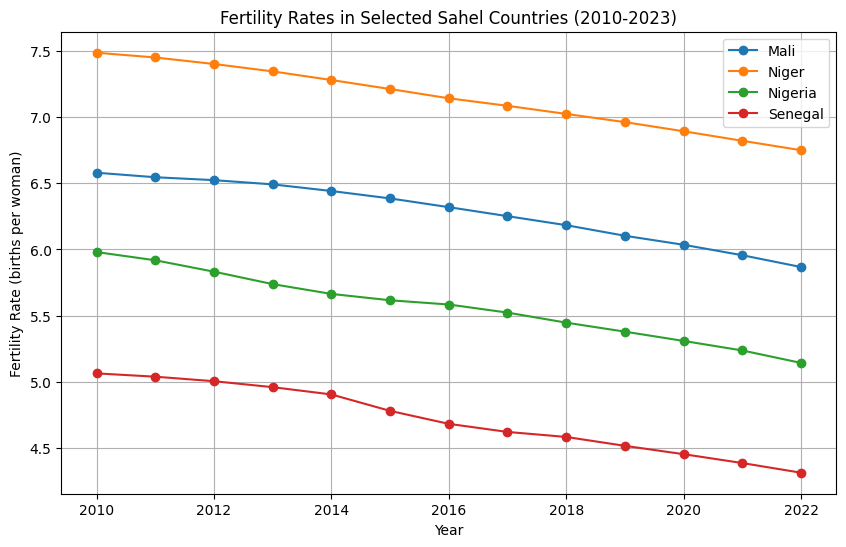

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Read the Sahel CSV
df = pd.read_csv("sahel_fertility_2010_2023.csv")

# 2) Convert from "wide" to "long" format so each row is (Country, Year, FertilityRate)
df_melt = df.melt(
    id_vars=["CountryName", "IndicatorName"],  # Columns to keep
    var_name="Year",
    value_name="FertilityRate"
)

# 3) Convert the "Year" column to integers (currently strings like "2010", "2011", etc.)
df_melt["Year"] = df_melt["Year"].astype(int)

# 4) Filter for specific countries: Niger, Mali, Senegal, Burkina Faso, Nigeria
countries_to_keep = ["Niger", "Mali", "Senegal", "Burkina Faso", "Nigeria"]
df_filtered = df_melt[df_melt["CountryName"].isin(countries_to_keep)]

# 5) Plot lines: one line per country across 2010-2023
plt.figure(figsize=(10, 6))
for country in df_filtered["CountryName"].unique():
    # Subset for this country
    sub_df = df_filtered[df_filtered["CountryName"] == country]

    # Sort by year (just to ensure lines plot correctly in ascending year order)
    sub_df = sub_df.sort_values("Year")

    # Plot line
    plt.plot(
        sub_df["Year"],
        sub_df["FertilityRate"],
        marker="o",
        label=country
    )

plt.title("Fertility Rates in Selected Sahel Countries (2010-2023)")
plt.xlabel("Year")
plt.ylabel("Fertility Rate (births per woman)")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
import pandas as pd

# 1) Read the Excel file
xlsx_file = "educatilon.xlsx"  # Update with your actual filename
df = pd.read_excel(xlsx_file)

# 2) Clean each cell: remove spaces, remove commas
for col in df.columns:
    # Convert column to string for safe replacements
    df[col] = df[col].astype(str)
    # Remove all spaces
    df[col] = df[col].str.replace(" ", "", regex=True)
    # Remove commas
    df[col] = df[col].str.replace(",", "", regex=True)

# 3) Keep only rows where Series is "Female_education"
df = df[df["Series"] == "Female_education"]

# 4) Drop the unwanted columns
df.drop(columns=["SeriesCode", "CountryCode"], inplace=True)

# 5) Save to CSV
df.to_csv("female_education.csv", index=False)
print("Saved 'female_education.csv' successfully.")


Saved 'female_education.csv' successfully.


In [5]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# 1) Read the CSV
df = pd.read_csv("female_education.csv")

# 2) Replace ".." with NaN in the entire DataFrame
df.replace("..", np.nan, inplace=True)

# 3) Identify numeric columns (e.g., year columns) to impute
#    Suppose the first 2 columns (CountryName, Series) are non-numeric:
numeric_cols = df.columns[2:]  # e.g. '2010', '2011', etc.

# 4) Convert those columns to numeric (coercing strings like '..' into NaN)
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Check how many NaNs now exist
print("Missing values BEFORE KNN imputation:")
print(df.isna().sum())

# 5) Apply KNN imputer on the numeric columns
imputer = KNNImputer(n_neighbors=3)  # or whatever n_neighbors you prefer
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# 6) Check missing again
print("\nMissing values AFTER KNN imputation:")
print(df.isna().sum())

# 7) Save the result to a new CSV
df.to_csv("female_education_imputed.csv", index=False)
print("\nSaved 'female_education_imputed.csv' with KNN‐imputed values.")


Missing values BEFORE KNN imputation:
CountryName    0
Series         0
2010           0
2011           0
2012           0
2013           2
2014           0
2015           2
2016           1
2017           3
2018           4
2019           3
dtype: int64

Missing values AFTER KNN imputation:
CountryName    0
Series         0
2010           0
2011           0
2012           0
2013           0
2014           0
2015           0
2016           0
2017           0
2018           0
2019           0
dtype: int64

Saved 'female_education_imputed.csv' with KNN‐imputed values.


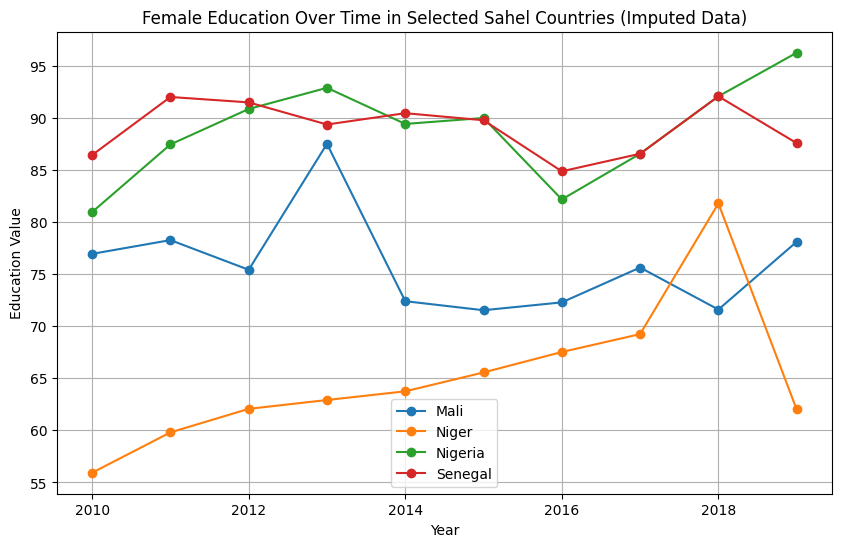

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Read the imputed CSV
df = pd.read_csv("female_education_imputed.csv")

# 2) Melt (reshape) from wide to long format:
df_melted = df.melt(
    id_vars=["CountryName", "Series"],
    var_name="Year",
    value_name="EduValue"
)

# 3) Convert "Year" to integer (if it’s like "2010", "2011" strings)
df_melted["Year"] = pd.to_numeric(df_melted["Year"], errors="coerce")

# 4) Filter for specific countries: Niger, Mali, Senegal, Burkina Faso, Nigeria
countries_to_keep = ["Niger", "Mali", "Senegal", "Burkina Faso", "Nigeria"]
df_filtered = df_melted[df_melted["CountryName"].isin(countries_to_keep)]

# 5) Plot lines – one line per country across the available years
plt.figure(figsize=(10, 6))

for country in df_filtered["CountryName"].unique():
    # Subset the data for this country
    sub_df = df_filtered[df_filtered["CountryName"] == country].sort_values("Year")

    # Plot a line of Year vs. Education Value
    plt.plot(
        sub_df["Year"],
        sub_df["EduValue"],
        marker="o",
        label=country
    )

plt.title("Female Education Over Time in Selected Sahel Countries (Imputed Data)")
plt.xlabel("Year")
plt.ylabel("Education Value")
plt.grid(True)
plt.legend()
plt.show()

In [7]:
import pandas as pd

# ====== STEP 1: LOAD & MELT FERTILITY DATA ======
fertility_df = pd.read_csv("sahel_fertility_2010_2023.csv")
# Suppose columns: [CountryName, 2010, 2011, ..., 2022]

fertility_melted = fertility_df.melt(
    id_vars=["CountryName"], 
    var_name="Year",
    value_name="FertilityRate"
)

# Convert Year to int
fertility_melted["Year"] = pd.to_numeric(fertility_melted["Year"], errors="coerce")

# ====== STEP 2: LOAD & MELT FEMALE EDUCATION DATA ======
edu_df = pd.read_csv("female_education.csv")
# Suppose columns: [CountryName, Series, 2010, 2011, ..., 2019]

edu_melted = edu_df.melt(
    id_vars=["CountryName", "Series"],
    var_name="Year",
    value_name="FemaleEduValue"
)

# Convert Year to int
edu_melted["Year"] = pd.to_numeric(edu_melted["Year"], errors="coerce")

# ====== STEP 3: MERGE ONLY ON 2010–2019 (intersection) ======

# We'll first filter each dataset to years 2010..2019:
fertility_melted = fertility_melted[
    (fertility_melted["Year"] >= 2010) & (fertility_melted["Year"] <= 2019)
].copy()

edu_melted = edu_melted[
    (edu_melted["Year"] >= 2010) & (edu_melted["Year"] <= 2019)
].copy()

# Now do an inner merge on (CountryName, Year)
merged_df = pd.merge(
    fertility_melted,
    edu_melted[["CountryName", "Year", "FemaleEduValue"]],  # keep only needed columns
    on=["CountryName", "Year"],
    how="inner"  # intersection
)

# ====== STEP 4: CHECK THE RESULT ======
print("Merged DataFrame (2010–2019) shape:", merged_df.shape)
print(merged_df.head())

# ====== STEP 5: (OPTIONAL) SAVE TO CSV ======
merged_df.to_csv("fertility_edu_2010_2019.csv", index=False)
print("Saved 'fertility_edu_2010_2019.csv'.")


Merged DataFrame (2010–2019) shape: (80, 4)
   CountryName    Year FertilityRate FemaleEduValue
0  BurkinaFaso  2010.0         5.936       74.28184
1     Cameroon  2010.0          5.16      100.18631
2       Guinea  2010.0         5.397       76.02468
3         Mali  2010.0         6.579       76.95044
4        Niger  2010.0         7.485       55.93311
Saved 'fertility_edu_2010_2019.csv'.


Correlation between Fertility Rate and Education Value: -0.8561419356294431


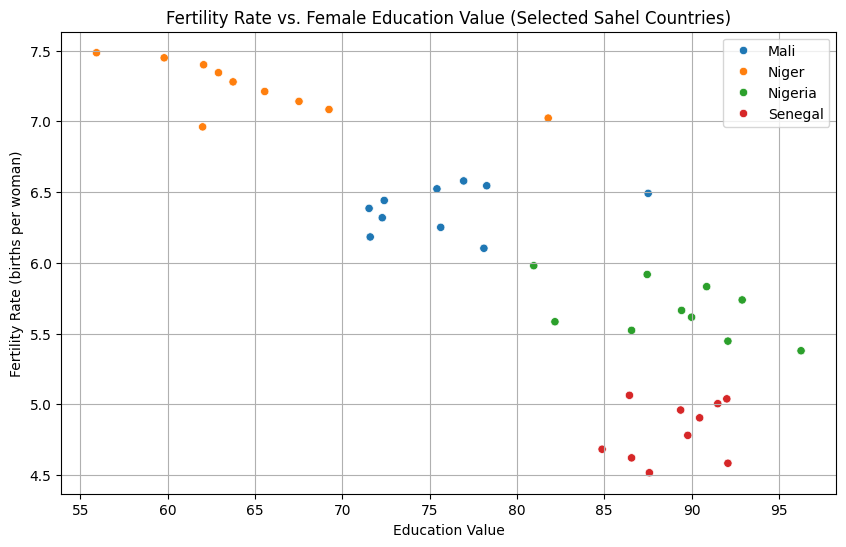

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load fertility data
df_fertility = pd.read_csv("sahel_fertility_2010_2023.csv")
df_fertility_melt = df_fertility.melt(
    id_vars=["CountryName", "IndicatorName"],
    var_name="Year",
    value_name="FertilityRate"
)
df_fertility_melt["Year"] = df_fertility_melt["Year"].astype(int)

# Load education data
df_education = pd.read_csv("female_education_imputed.csv")
df_education_melt = df_education.melt(
    id_vars=["CountryName", "Series"],
    var_name="Year",
    value_name="EduValue"
)
df_education_melt["Year"] = pd.to_numeric(df_education_melt["Year"], errors="coerce")

# Merge the datasets on CountryName and Year
df_merged = pd.merge(df_fertility_melt, df_education_melt, on=["CountryName", "Year"])

# Filter for specific countries: Niger, Mali, Senegal, Burkina Faso, Nigeria
countries_to_keep = ["Niger", "Mali", "Senegal", "Burkina Faso", "Nigeria"]
df_filtered = df_merged[df_merged["CountryName"].isin(countries_to_keep)]

# Calculate correlation
correlation = df_filtered['FertilityRate'].corr(df_filtered['EduValue'])
print(f"Correlation between Fertility Rate and Education Value: {correlation}")

# Scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x="EduValue", y="FertilityRate", hue="CountryName")
plt.title("Fertility Rate vs. Female Education Value (Selected Sahel Countries)")
plt.xlabel("Education Value")
plt.ylabel("Fertility Rate (births per woman)")
plt.grid(True)
plt.legend()
plt.show()

In [9]:
import pandas as pd

# Load the population density CSV file
df = pd.read_csv("population_density.csv")

# List of countries to keep
countries = ["Senegal", "Mali", "Burkina Faso", "Niger", "Nigeria"]

# Filter rows for the specified countries
df_filtered = df[df["country"].isin(countries)]

# Select only the columns for the years 2010-2019
years = [str(year) for year in range(2010, 2020)]  # Create a list of years as strings
columns_to_keep = ["country"] + years  # Include "Country" and the year columns
df_filtered = df_filtered[columns_to_keep]

# Save the filtered data to a new CSV file (optional)
df_filtered.to_csv("filtered_population_density.csv", index=False)

# Display the filtered DataFrame
print(df_filtered)

          country  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019
17   Burkina Faso  59.1  60.9  62.8  64.7  66.6  68.6  70.7  72.7  74.7  76.6
136          Mali  13.1  13.5  13.9  14.3  14.8  15.2  15.7  16.2  16.8  17.3
152         Niger  13.1  13.6  14.1  14.6  15.2  15.7  16.3  16.9  17.5  18.1
153       Nigeria   183   188   193   199   204   209   215   220   225   230
183       Senegal  65.6  67.3  69.1  71.2  73.5  75.8  78.1  80.4  82.7  84.9


Correlation between Population Density and Education Value: 0.6696298742868055


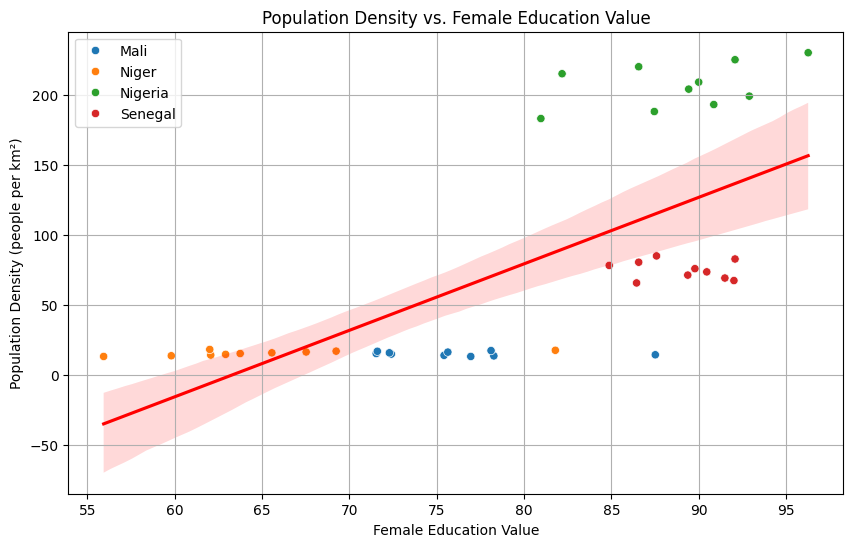

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the filtered population density data
df_population = pd.read_csv("filtered_population_density.csv")

# Melt the population density data to long format for merging
df_population_melt = df_population.melt(
    id_vars=["country"],
    var_name="Year",
    value_name="PopulationDensity"
)
df_population_melt["Year"] = df_population_melt["Year"].astype(int)

# Load the education data
df_education = pd.read_csv("female_education_imputed.csv")
df_education_melt = df_education.melt(
    id_vars=["CountryName", "Series"],
    var_name="Year",
    value_name="FemaleEduValue"
)
df_education_melt["Year"] = pd.to_numeric(df_education_melt["Year"], errors="coerce")

# Merge the datasets on CountryName and Year
df_final = pd.merge(df_population_melt, df_education_melt, left_on=["country", "Year"], right_on=["CountryName", "Year"])

# Calculate correlation between population density and education value
correlation = df_final['PopulationDensity'].corr(df_final['FemaleEduValue'])
print(f"Correlation between Population Density and Education Value: {correlation}")

# Scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x="FemaleEduValue", y="PopulationDensity", hue="country")
sns.regplot(data=df_final, x="FemaleEduValue", y="PopulationDensity", scatter=False, color="red")
plt.title("Population Density vs. Female Education Value")
plt.xlabel("Female Education Value")
plt.ylabel("Population Density (people per km²)")
plt.grid(True)
plt.legend()
plt.show()

Correlation between Population Density and Fertility Rate: -0.5065012489383592


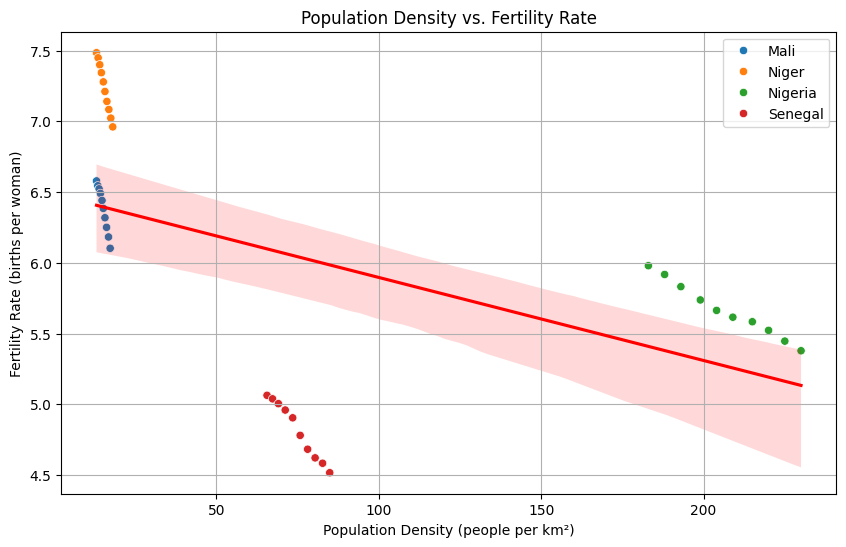

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the filtered population density data
df_population = pd.read_csv("filtered_population_density.csv")

# Melt the population density data to long format for merging
df_population_melt = df_population.melt(
    id_vars=["country"],
    var_name="Year",
    value_name="PopulationDensity"
)
df_population_melt["Year"] = df_population_melt["Year"].astype(int)

# Load the fertility data
df_fertility = pd.read_csv("Sahel_fertility_2010_2023.csv")
df_fertility_melt = df_fertility.melt(
    id_vars=["CountryName", "IndicatorName"],
    var_name="Year",
    value_name="FertilityRate"
)
df_fertility_melt["Year"] = df_fertility_melt["Year"].astype(int)

# Merge the datasets on CountryName and Year
df_final = pd.merge(df_population_melt, df_fertility_melt, left_on=["country", "Year"], right_on=["CountryName", "Year"])

# Calculate correlation between population density and fertility rate
correlation = df_final['PopulationDensity'].corr(df_final['FertilityRate'])
print(f"Correlation between Population Density and Fertility Rate: {correlation}")

# Scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x="PopulationDensity", y="FertilityRate", hue="country")
sns.regplot(data=df_final, x="PopulationDensity", y="FertilityRate", scatter=False, color="red")
plt.title("Population Density vs. Fertility Rate")
plt.xlabel("Population Density (people per km²)")
plt.ylabel("Fertility Rate (births per woman)")
plt.grid(True)
plt.legend()
plt.show()